![image.png](https://i.imgur.com/a3uAqnb.png)

In [1]:
# Cell 1: Install required packages
!pip install ultralytics roboflow opencv-python --quiet

In [2]:
# Cell 2: Import libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from roboflow import Roboflow
from IPython.display import Image, display
from google.colab.patches import cv2_imshow # Colab-specific display function

In [3]:
# Cell 3: Download Segmentation Dataset from Roboflow Universe

rf = Roboflow(api_key="2dJeWPtOuxQmN2hTMrIr")

project = rf.workspace("roboflow-universe-projects").project("fire-and-smoke-segmentation")

dataset = project.version(6).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [4]:
# Path to the dataset configuration file (data.yaml)
DATA_PATH = os.path.join(dataset.location, "data.yaml")
print(f"Dataset downloaded to: {dataset.location}")

Dataset downloaded to: /content/Fire-and-Smoke-Segmentation-6


Class Names: ['fire', 'smoke']


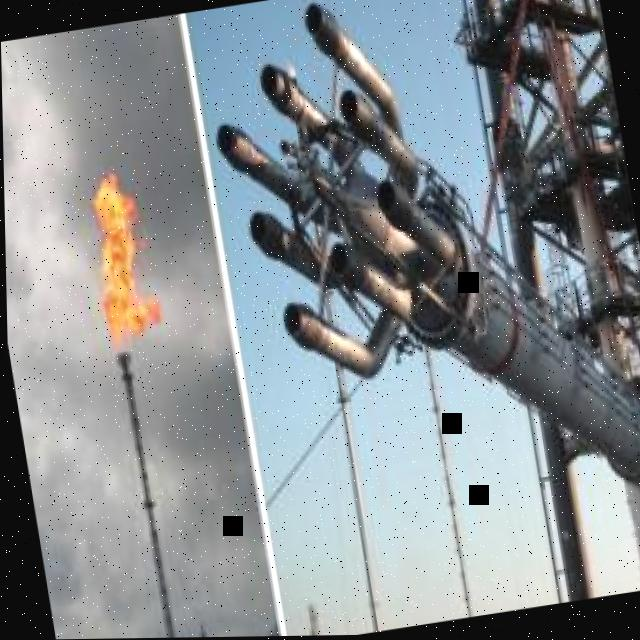

In [5]:
# Cell 4: Define Class Names and Inspect Data

# These are the class names for the 'Fire and Smoke Segmentation' project
class_names = ['fire', 'smoke']

print(f"Class Names: {class_names}")

train_image_dir = os.path.join(dataset.location, 'train', 'images')
random_image = random.choice(os.listdir(train_image_dir))
display(Image(filename=os.path.join(train_image_dir, random_image), width=400))

In [8]:
!find . -name "*.cache" -delete
print("All *.cache files have been deleted from the current directory and its subfolders.")

All *.cache files have been deleted from the current directory and its subfolders.


In [15]:
# Cell 5: Train the YOLOv8 Instance Segmentation Model

# Load the YOLO segmentation model (yolov8n-seg.pt)

# --- Ensure all cache files are deleted before training ---
# This is crucial to prevent EOFError due to corrupted cache files.
# Using `!find` is more comprehensive than Python's glob for this task across subdirectories.
!find . -name "*.cache" -delete
print("All *.cache files have been deleted from the current directory and its subfolders.")

model = YOLO('yolov8n-seg.pt')

!yolo task=segment \
    mode=train \
    model=yolov8n-seg.pt \
    data={DATA_PATH} \
    epochs=5 \
    imgsz=640 \
    batch=16 \
    name=fire_and_smoke \
    cache=False  # Explicitly disable caching for this run

# Define the path to the best model weights after training
BEST_MODEL_PATH = f'{os.getcwd()}/runs/segment/fire_and_smoke/weights/best.pt'
print(f"Trained model weights path: {BEST_MODEL_PATH}")

All *.cache files have been deleted from the current directory and its subfolders.
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Fire-and-Smoke-Segmentation-6/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fire_and_smoke2, nbs=64, nms=Fal

### Abstracted Code (Using YOLO's Built-in Plotting)

This cell demonstrates running inference and displaying the results using YOLO's integrated `plot()` method, which abstracts away the manual drawing of masks and bounding boxes. This is generally the more straightforward approach for visualization unless specific custom rendering is required.

In [34]:
# Load the trained model
BEST_MODEL_PATH = f'{os.getcwd()}/runs/segment/fire_and_smoke2/weights/best.pt'
trained_model = YOLO(BEST_MODEL_PATH)

# Select a random image from the dataset's test set
test_image_dir = os.path.join(dataset.location, 'test', 'images')
random_test_image_filename = random.choice(os.listdir(test_image_dir))
TEST_IMAGE_PATH = os.path.join(test_image_dir, random_test_image_filename)
print(f"Using test image: {TEST_IMAGE_PATH}")

# Run inference and directly plot the results
# The 'save=True' option will save the annotated image to a 'runs/segment/predict' directory.
# The 'show=True' option will display the image directly in the notebook.
results = trained_model.predict(
    source=TEST_IMAGE_PATH,
    task='segment',
    conf=0.6,
    iou=0.7,
    save=True,
    show=True,
    name='fire_and_smoke_abstracted_pred'
)

Using test image: /content/Fire-and-Smoke-Segmentation-6/test/images/flare_0104_jpg.rf.f5405c4145dae97134f7acb2aae153a1.jpg

image 1/1 /content/Fire-and-Smoke-Segmentation-6/test/images/flare_0104_jpg.rf.f5405c4145dae97134f7acb2aae153a1.jpg: 640x640 1 fire, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/segment/fire_and_smoke_abstracted_pred11


### Inspecting Ground Truth Mask Labels

For YOLOv8 segmentation datasets, the ground truth mask labels are stored in `.txt` files. Each file corresponds to an image and contains the class ID followed by the normalized coordinates of the polygon for each segmented object. Let's inspect a random example.

In [35]:
# Cell to display a random ground truth label file

import os
import random


# Assuming dataset.location is defined from Cell 3
train_labels_dir = os.path.join(dataset.location, 'train', 'labels')

# Get a list of all label files
label_files = [f for f in os.listdir(train_labels_dir) if f.endswith('.txt')]

# Pick a random label file
random_label_filename = random.choice(label_files)
random_label_filepath = os.path.join(train_labels_dir, random_label_filename)

print(f"Inspecting ground truth label file: {random_label_filepath}")

with open(random_label_filepath, 'r') as f:
    label_content = f.read()

print("\n--- Content of the label file ---")
print(label_content)

Inspecting ground truth label file: /content/Fire-and-Smoke-Segmentation-6/train/labels/flare_0106_jpg.rf.ce96ea774a618a780c2c279fac95ecbd.txt

--- Content of the label file ---
0 0.4483547875 0 0.43212311562499994 0.0015145203125 0.43385125625 0.0048746734375 0.42744265937500003 0.0122986125 0.41367178125 0.0162055015625 0.40680957656250005 0.0094978296875 0.39569311875 0.016835040625 0.3944520171875 0.0295507890625 0.3986127875 0.041240523437499996 0.41832784375000004 0.042548957812499996 0.423814678125 0.05148897031250001 0.42294426406249996 0.0594441484375 0.411823821875 0.06678173125 0.40409314375000005 0.0769550203125 0.4053237828125 0.0910141296875 0.39466138281249996 0.09463499375 0.388623471875 0.0972983609375 0.386698721875 0.10220393750000001 0.396165690625 0.11182056250000001 0.40302824375 0.1185322171875 0.40288520781250003 0.1258935265625 0.39872070000000004 0.1320600875 0.40155709999999994 0.13756940625 0.40718263749999994 0.1391444984375 0.4157836265625 0.138867971875 0

Using test image: /content/Fire-and-Smoke-Segmentation-6/test/images/flare_0222_jpg.rf.437f423df9226a799cdf906e200d2532.jpg

image 1/1 /content/Fire-and-Smoke-Segmentation-6/test/images/flare_0222_jpg.rf.437f423df9226a799cdf906e200d2532.jpg: 640x640 1 fire, 1 smoke, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/segment/fire_and_smoke_abstracted_pred17


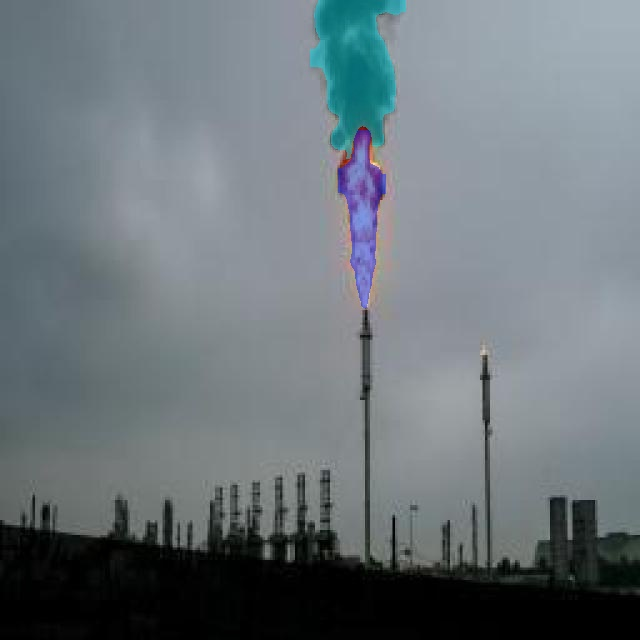

In [41]:
# Load the trained model
BEST_MODEL_PATH = f'{os.getcwd()}/runs/segment/fire_and_smoke2/weights/best.pt'
trained_model = YOLO(BEST_MODEL_PATH)

# Select a random image from the dataset's test set
test_image_dir = os.path.join(dataset.location, 'test', 'images')
random_test_image_filename = random.choice(os.listdir(test_image_dir))
TEST_IMAGE_PATH = os.path.join(test_image_dir, random_test_image_filename)
print(f"Using test image: {TEST_IMAGE_PATH}")

# Run inference and directly plot the results
# The 'save=True' option will save the annotated image to a 'runs/segment/predict' directory.
# The 'show=True' option will display the image directly in the notebook.
# Added show_boxes=False and show_labels=False to display only segmentation masks.
results = trained_model.predict(
    source=TEST_IMAGE_PATH,
    task='segment',
    conf=0.1,
    iou=0.7,
    save=True,
    show=True,
    show_boxes=False,    # Do not display bounding boxes
    show_labels=True,   # Do not display class labels for boxes
    name='fire_and_smoke_abstracted_pred'
)

# Extract the actual output directory from the results object (more robust approach)
# The 'save_dir' attribute of the first result object contains the path to the directory where results were saved.
output_dir = results[0].save_dir

# The filename of the saved image will be the same as the random test image filename
saved_image_path = os.path.join(output_dir, random_test_image_filename)

# Check if the file exists before attempting to display
if os.path.exists(saved_image_path):
    display(Image(filename=saved_image_path, width=600))
else:
    print(f"Error: Saved image not found at {saved_image_path}. Please verify the 'output_dir' matches the actual directory where the results were saved.")
